## 판매실적 회귀 모델 개발
---


In [102]:
실적 = pd.read_csv('실적.csv')

In [104]:
실적_전처리 = 실적[['노출(분)','상품군','판매단가범위','시청률평균','판매수량','무슨요일','몇시']]
실적_전처리.info()       

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37372 entries, 0 to 37371
Data columns (total 7 columns):
노출(분)     37372 non-null float64
상품군       37372 non-null object
판매단가범위    37372 non-null object
시청률평균     37372 non-null float64
판매수량      35379 non-null float64
무슨요일      37372 non-null object
몇시        37372 non-null object
dtypes: float64(3), object(4)
memory usage: 2.0+ MB


In [105]:
실적_전처리=실적_전처리.dropna()

In [106]:
실적_전처리.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35379 entries, 0 to 37371
Data columns (total 7 columns):
노출(분)     35379 non-null float64
상품군       35379 non-null object
판매단가범위    35379 non-null object
시청률평균     35379 non-null float64
판매수량      35379 non-null float64
무슨요일      35379 non-null object
몇시        35379 non-null object
dtypes: float64(3), object(4)
memory usage: 2.2+ MB


In [ ]:
실적_전처리.to_csv('실적전처리.csv',index=False)

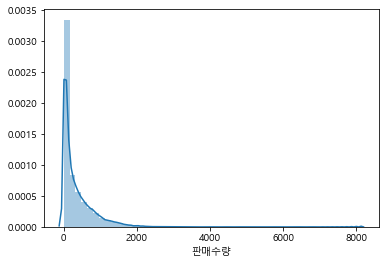

In [107]:
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('font',family = 'malgun gothic')

sns.distplot(실적_전처리['판매수량'])

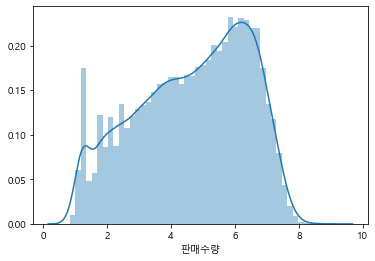

In [17]:
# 데이터 정규화
log = np.log1p(실적_전처리['판매수량'])
sns.distplot(log)

In [108]:
#판매수량 로그 변환
실적_전처리['판매수량'] =np.log1p(실적_전처리['판매수량'])

# 원핫인코딩
실적_전처리_원핫 = pd.get_dummies(실적_전처리)
실적_전처리_원핫.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35379 entries, 0 to 37371
Data columns (total 48 columns):
노출(분)             35379 non-null float64
시청률평균             35379 non-null float64
판매수량              35379 non-null float64
상품군_가구            35379 non-null uint8
상품군_가전            35379 non-null uint8
상품군_건강기능          35379 non-null uint8
상품군_농수축           35379 non-null uint8
상품군_생활용품          35379 non-null uint8
상품군_속옷            35379 non-null uint8
상품군_의류            35379 non-null uint8
상품군_이미용           35379 non-null uint8
상품군_잡화            35379 non-null uint8
상품군_주방            35379 non-null uint8
상품군_침구            35379 non-null uint8
판매단가범위_100만원이상    35379 non-null uint8
판매단가범위_100만원이하    35379 non-null uint8
판매단가범위_10만원이하     35379 non-null uint8
판매단가범위_30만원이하     35379 non-null uint8
판매단가범위_50만원이하     35379 non-null uint8
판매단가범위_5만원이하      35379 non-null uint8
무슨요일_Friday       35379 non-null uint8
무슨요일_Monday       35379 non-null uint8
무슨요일_Saturday     35379 non

In [22]:
def get_rmse(model):
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test , pred)
    rmse = np.sqrt(mse)
    print('{0} 로그 변환된 RMSE: {1}'.format(model.__class__.__name__,np.round(rmse, 3)))
    return rmse

def get_rmses(models):
    rmses = [ ]
    for model in models:
        rmse = get_rmse(model)
        rmses.append(rmse)
    return rmses

In [109]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

y_target = 실적_전처리_원핫['판매수량']
X_features = 실적_전처리_원핫.drop('판매수량',axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

# LinearRegression, Ridge, Lasso 학습, 예측, 평가
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)

ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)

lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)


LinearRegression 로그 변환된 RMSE: 0.874
Ridge 로그 변환된 RMSE: 0.874
Lasso 로그 변환된 RMSE: 1.744


[0.8741857266669426, 0.8741595582567354, 1.744138638699432]

In [110]:
def get_top_bottom_coef(model):
    # coef_ 속성을 기반으로 Series 객체를 생성. index는 컬럼명. 
    coef = pd.Series(model.coef_, index=X_features.columns)
    
    # + 상위 10개 , - 하위 10개 coefficient 추출하여 반환.
    coef_high = coef.sort_values(ascending=False).head(10)
    coef_low = coef.sort_values(ascending=False).tail(10)
    return coef_high, coef_low


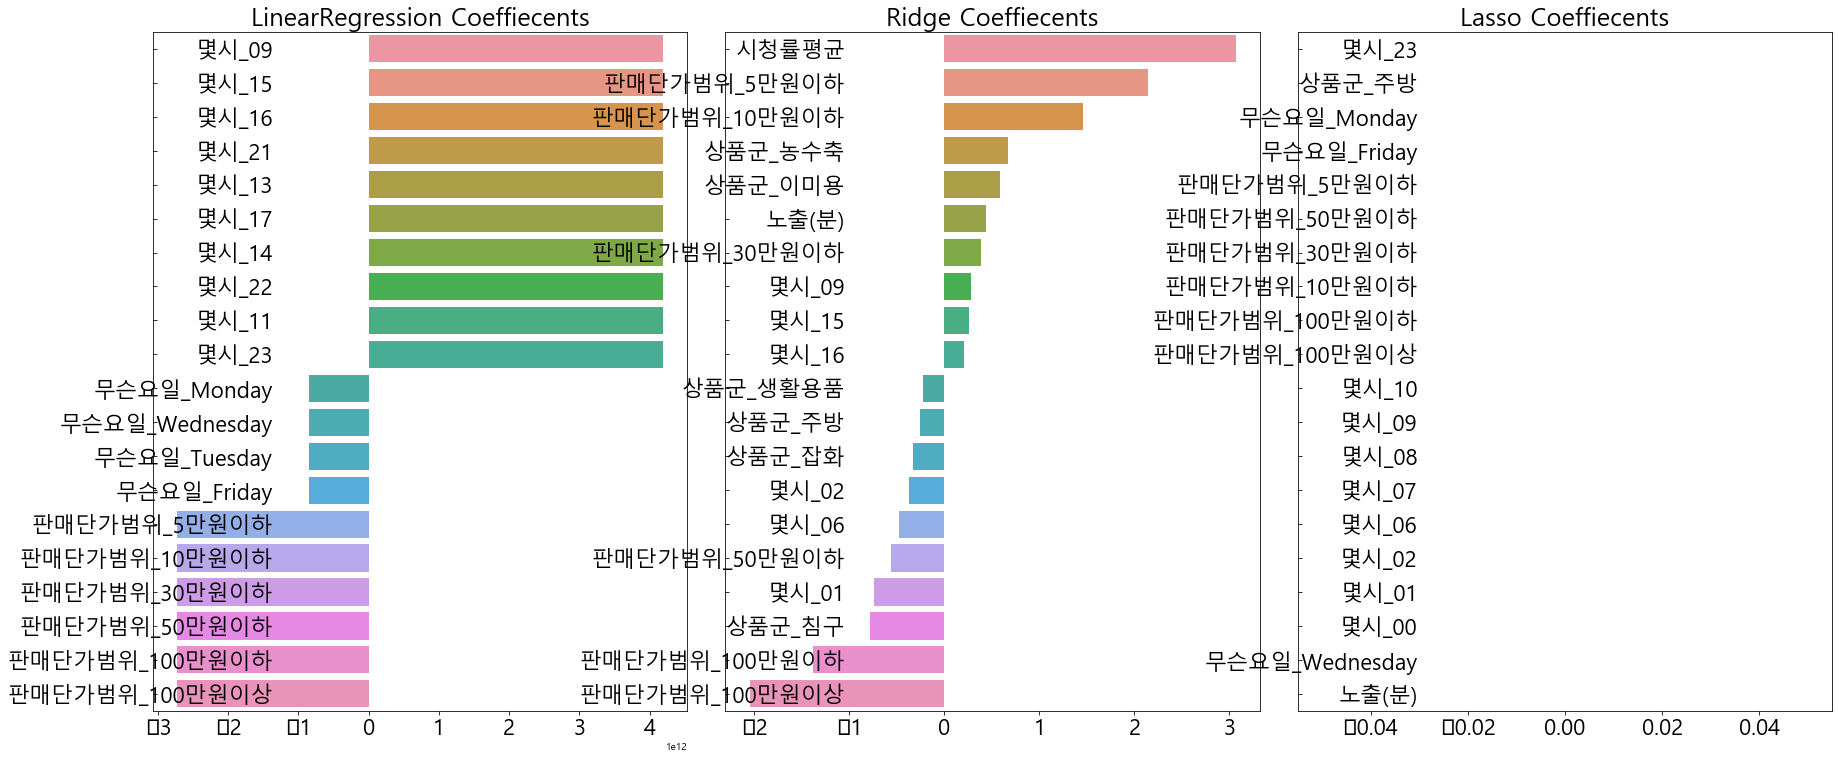

In [25]:
def visualize_coefficient(models):
    # 3개 회귀 모델의 시각화를 위해 3개의 컬럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(24,10),nrows=1, ncols=3)
    fig.tight_layout() 
    # 입력인자로 받은 list객체인 models에서 차례로 model을 추출하여 회귀 계수 시각화. 
    for i_num, model in enumerate(models):
        # 상위 10개, 하위 10개 회귀 계수를 구하고, 이를 판다스 concat으로 결합. 
        coef_high, coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat( [coef_high , coef_low] )
        # 순차적으로 ax subplot에 barchar로 표현. 한 화면에 표현하기 위해 tick label 위치와 font 크기 조정. 
        axs[i_num].set_title(model.__class__.__name__+' Coeffiecents', size=25)
        axs[i_num].tick_params(axis="y",direction="in", pad=-120)
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=coef_concat.values, y=coef_concat.index , ax=axs[i_num])

# 앞 예제에서 학습한 lr_reg, ridge_reg, lasso_reg 모델의 회귀 계수 시각화.    
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)


In [26]:
from sklearn.model_selection import cross_val_score

def get_avg_rmse_cv(models):
    for model in models:
        # 분할하지 않고 전체 데이터로 cross_val_score( ) 수행. 모델별 CV RMSE값과 평균 RMSE 출력
        rmse_list = np.sqrt(-cross_val_score(model, X_features, y_target,
                                             scoring="neg_mean_squared_error", cv = 5))
        rmse_avg = np.mean(rmse_list)
        print('\n{0} CV RMSE 값 리스트: {1}'.format( model.__class__.__name__, np.round(rmse_list, 3)))
        print('{0} CV 평균 RMSE 값: {1}'.format( model.__class__.__name__, np.round(rmse_avg, 3)))

# 앞 예제에서 학습한 lr_reg, ridge_reg, lasso_reg 모델의 CV RMSE값 출력           
models = [lr_reg, ridge_reg, lasso_reg]
get_avg_rmse_cv(models)


LinearRegression CV RMSE 값 리스트: [9.03000000e-01 8.30000000e-01 8.46000000e-01 8.79000000e-01
 1.30128038e+11]
LinearRegression CV 평균 RMSE 값: 26025607531.638

Ridge CV RMSE 값 리스트: [0.903 0.831 0.846 0.878 0.921]
Ridge CV 평균 RMSE 값: 0.876

Lasso CV RMSE 값 리스트: [1.702 1.823 1.745 1.791 1.671]
Lasso CV 평균 RMSE 값: 1.746


In [27]:

from sklearn.model_selection import GridSearchCV

def print_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid=params, 
                              scoring='neg_mean_squared_error', cv=5)
    grid_model.fit(X_features, y_target)
    rmse = np.sqrt(-1* grid_model.best_score_)
    print('{0} 5 CV 시 최적 평균 RMSE 값: {1}, 최적 alpha:{2}'.format(model.__class__.__name__,
                                        np.round(rmse, 4), grid_model.best_params_))
    return grid_model.best_estimator_

ridge_params = { 'alpha':[0.001, 0.005, 0.008,0.01,0.03,0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0,0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }
best_rige = print_best_params(ridge_reg, ridge_params)
best_lasso = print_best_params(lasso_reg, lasso_params)


Ridge 5 CV 시 최적 평균 RMSE 값: 0.8764, 최적 alpha:{'alpha': 0.01}
Lasso 5 CV 시 최적 평균 RMSE 값: 0.8765, 최적 alpha:{'alpha': 0}


LinearRegression 로그 변환된 RMSE: 0.873
Ridge 로그 변환된 RMSE: 0.873
Lasso 로그 변환된 RMSE: 0.873


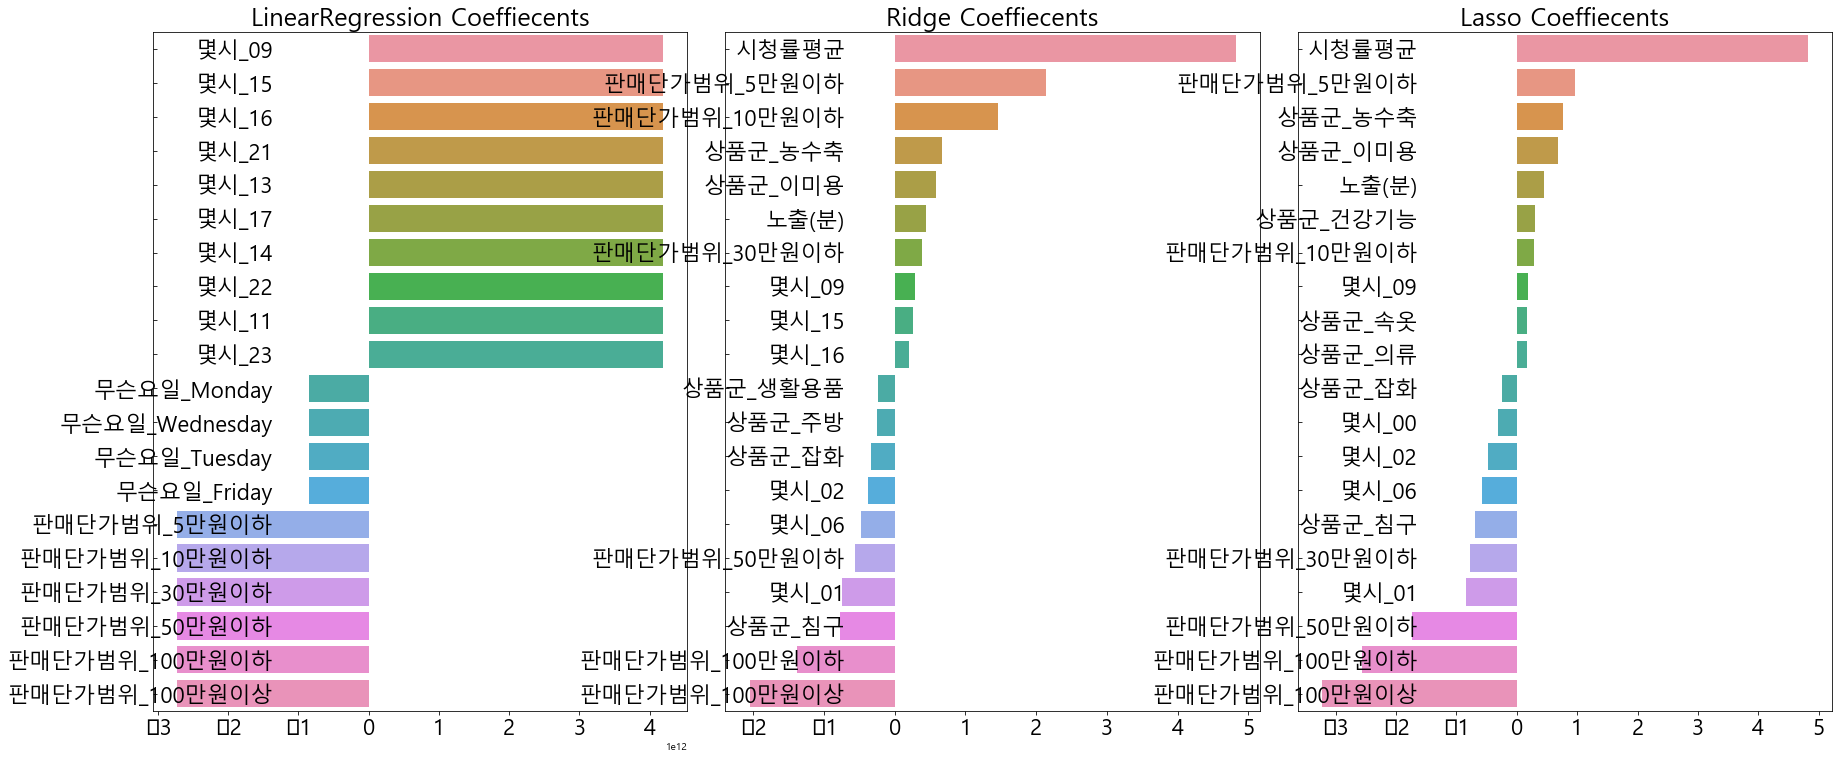

In [28]:
# 앞의 최적화 alpha값으로 학습데이터로 학습, 테스트 데이터로 예측 및 평가 수행. 
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=0.001)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0)
lasso_reg.fit(X_train, y_train)

# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

# 모든 모델의 회귀 계수 시각화 
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

In [111]:
from scipy.stats import skew

# object가 아닌 숫자형 피쳐의 컬럼 index 객체 추출.
features_index = 실적_전처리.dtypes[실적_전처리.dtypes != 'object'].index
# house_df에 컬럼 index를 [ ]로 입력하면 해당하는 컬럼 데이터 셋 반환. apply lambda로 skew( )호출 
skew_features = 실적_전처리[features_index].apply(lambda x : skew(x))
# skew 정도가 1 이상인 컬럼들만 추출. 
skew_features_top = skew_features[skew_features > 1]
print(skew_features_top.sort_values(ascending=False))

노출(분)    1.041644
dtype: float64


In [112]:
실적_전처리[skew_features_top.index] = np.log1p(실적_전처리[skew_features_top.index])

In [29]:
# Skew가 높은 피처들을 로그 변환 했으므로 다시 원-핫 인코딩 적용 및 피처/타겟 데이터 셋 생성,
실적_전처리_원핫 = pd.get_dummies(실적_전처리)
y_target = 실적_전처리_원핫['판매수량']
X_features = 실적_전처리_원핫.drop('판매수량',axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

# 피처들을 로그 변환 후 다시 최적 하이퍼 파라미터와 RMSE 출력
ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }
best_ridge = print_best_params(ridge_reg, ridge_params)
best_lasso = print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값: 0.8764, 최적 alpha:{'alpha': 0.05}
Lasso 5 CV 시 최적 평균 RMSE 값: 0.8773, 최적 alpha:{'alpha': 0.001}


LinearRegression 로그 변환된 RMSE: 0.874
Ridge 로그 변환된 RMSE: 0.874
Lasso 로그 변환된 RMSE: 0.874


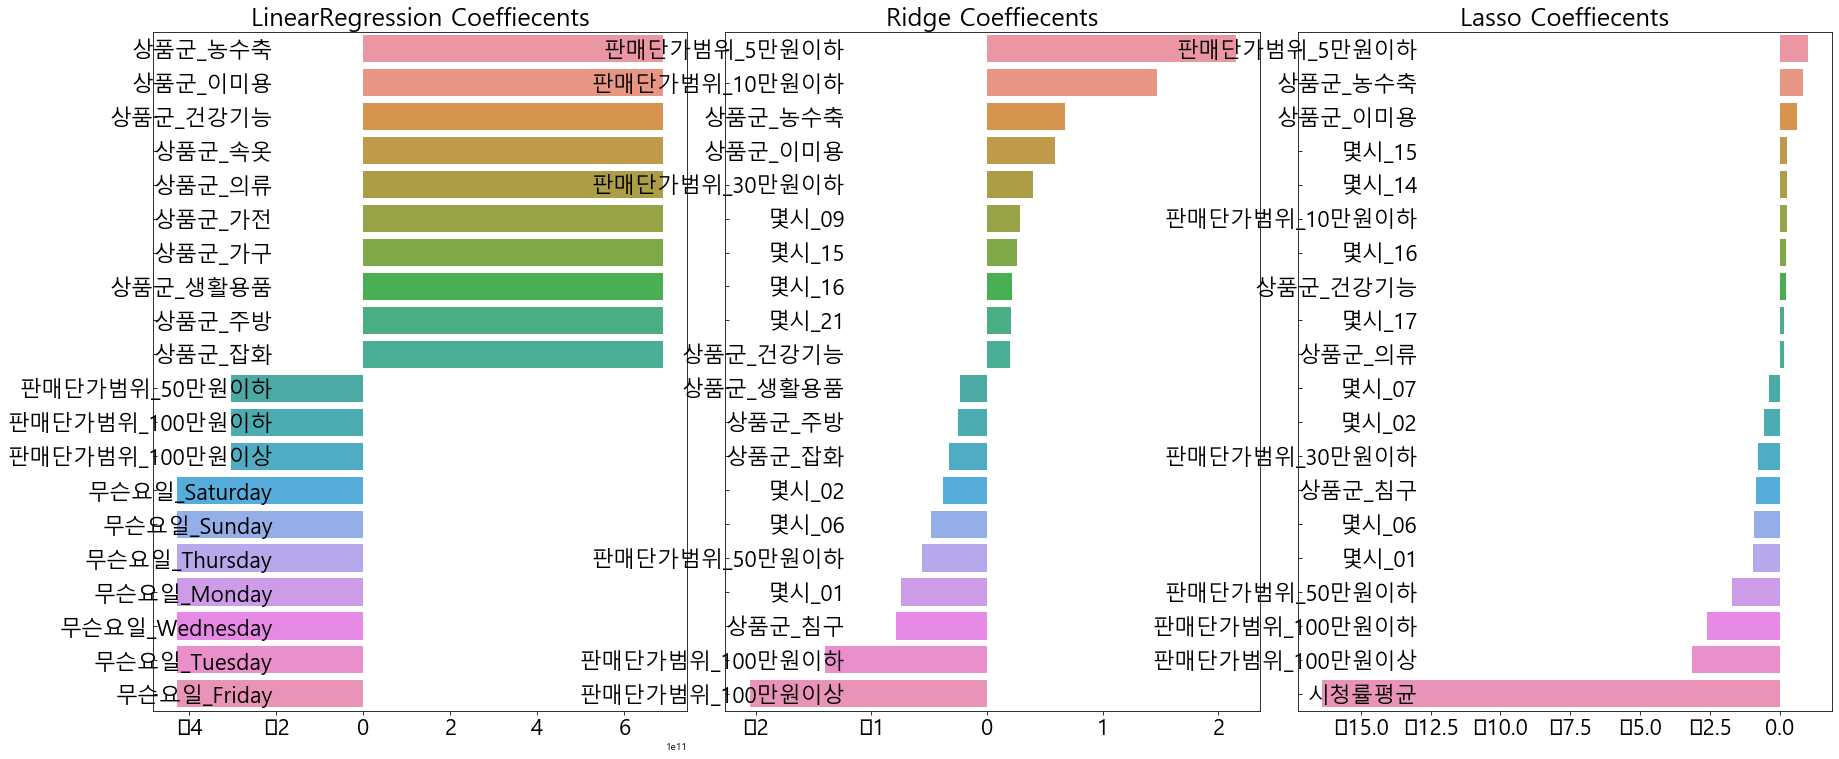

In [113]:
# 앞의 최적화 alpha값으로 학습데이터로 학습, 테스트 데이터로 예측 및 평가 수행. 
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=0.05)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0)
lasso_reg.fit(X_train, y_train)

# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

# 모든 모델의 회귀 계수 시각화 
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

LinearRegression 로그 변환된 RMSE: 0.873
Ridge 로그 변환된 RMSE: 0.873
Lasso 로그 변환된 RMSE: 0.873


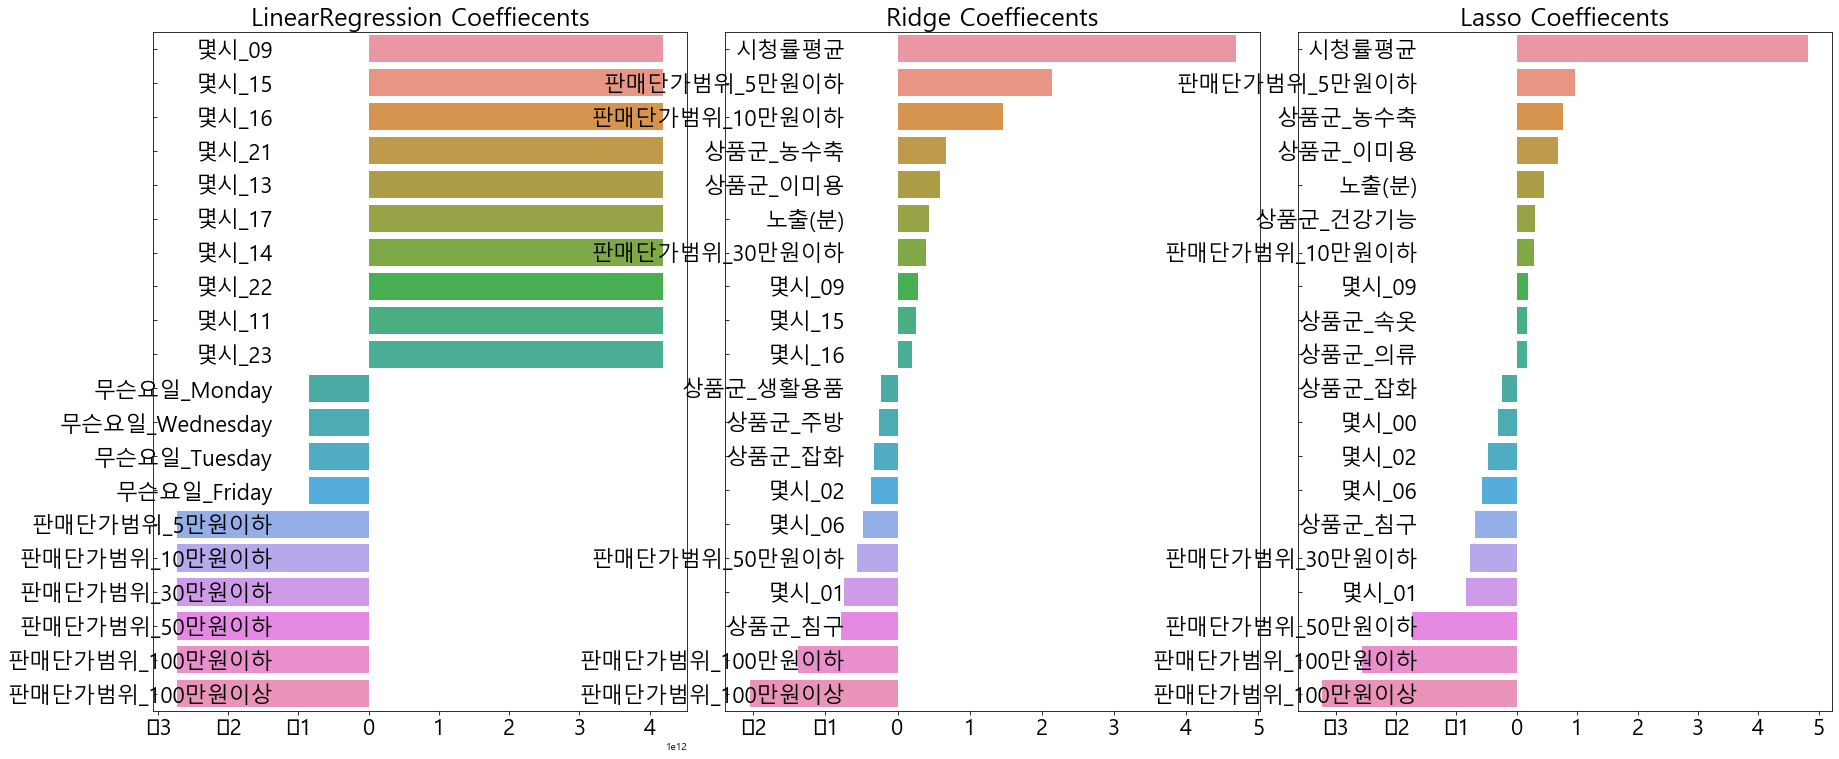

In [31]:
# 앞의 최적화 alpha값으로 학습데이터로 학습, 테스트 데이터로 예측 및 평가 수행. 
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=0.05)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0)
lasso_reg.fit(X_train, y_train)

# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

# 모든 모델의 회귀 계수 시각화 
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

In [ ]:
def get_rmse_pred(preds):
    for key in preds.keys():
        pred_value = preds[key]
        mse = mean_squared_error(y_test , pred_value)
        rmse = np.sqrt(mse)
        print('{0} 모델의 RMSE: {1}'.format(key, rmse))

# 개별 모델의 학습
ridge_reg = Ridge(alpha=0.05)
ridge_reg.fit(X_train, y_train)
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
# 개별 모델 예측
ridge_pred = ridge_reg.predict(X_test)
lr_pred = lr_reg.predict(X_test)

# 개별 모델 예측값 혼합으로 최종 예측값 도출
pred = 0.5 * ridge_pred + 0.5 * lasso_pred
preds = {'최종 혼합': pred,
         'Ridge': ridge_pred,
         'Lasso': lasso_pred}
#최종 혼합 모델, 개별모델의 RMSE 값 출력
get_rmse_pred(preds)


In [114]:
ridge_reg.coef_

array([ 1.83590212e-02,  1.54926137e-02, -6.98188598e-02,  6.52790587e-02,
        2.00121967e-01,  6.72490266e-01, -2.30083299e-01,  7.01517938e-02,
        6.52203545e-02,  5.88655454e-01, -3.25207694e-01, -2.52009463e-01,
       -7.84799578e-01, -2.05332531e+00, -1.39844747e+00,  1.47003097e+00,
        3.98305687e-01, -5.63761085e-01,  2.14719721e+00, -6.33867585e-02,
       -2.85647929e-02,  1.05022500e-01,  8.03388175e-02, -6.79785915e-03,
       -4.82252801e-02, -3.83866266e-02, -2.13054261e-01, -7.47917955e-01,
       -3.80567032e-01, -4.85253057e-01,  1.56979598e-03,  3.07853073e-02,
        2.82474604e-01,  7.38410222e-02,  1.26726682e-01,  2.14741359e-02,
        1.69333161e-01,  1.32835702e-01,  2.56602961e-01,  2.12212549e-01,
        1.57785126e-01,  2.33042338e-03, -9.17182229e-02,  3.82000438e-02,
        2.05545190e-01,  1.20799714e-01,  8.59941129e-02])